In [424]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o

## Result Gathering

In [438]:
main_df = None
directory = "Effort_Estimation_Results_v5/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Alluxio.csv
Assertj-core.csv
Atmosphere.csv
AxonFramework.csv
Beam.csv
Byte-buddy.csv
Camel.csv
Cxf.csv
Dbeaver.csv
Hadoop.csv
Okhttp.csv
Redisson.csv


In [439]:
main_df.head()

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,num_line_affected_min,num_line_affected_max,num_line_affected_std,actual_num_of_classes_touched_mean,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken
0,3,19.225678,1.0,167.0,1.0,2.0,2.0,3.0,4.0,7.0,...,24,1245,682.248,35.0,1,54,29.512709,2162,0.011101,1.0
1,3,19.225678,1.0,167.0,1.0,2.0,2.0,3.0,4.0,7.0,...,242,242,0.000,4.0,4,4,0.000000,142,1.000000,1.0
2,6,12.820546,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,61,61,NaN,2.0,2,2,NaN,8,1.000000,15.0
3,6,12.820546,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,78,78,NaN,1.0,1,1,NaN,346,0.225434,1.0
4,6,12.820546,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,322,322,0.000,1.5,1,2,0.707107,35,1.000000,1.0


In [440]:
for column in main_df:
    print(column)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

In [441]:
len(main_df)

366

In [442]:
def plotGraph(y_test,y_pred,regressorName):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.scatter(range(len(y_test)), y_test, color='blue', label='y_test')
    plt.scatter(range(len(y_pred)), y_pred, color='red', label='y_pred')
    plt.title(regressorName)
    plt.legend(loc="upper left")
    plt.show()
    return

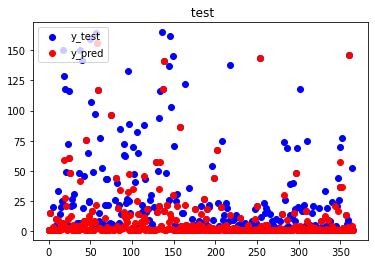

In [443]:
plotGraph(main_df['time_taken'], main_df['refactoring_perc_time_taken'],' test')

In [444]:
def get_final_time_taken(row):
    if row['time_taken'] > row['time_taken_q90']:
        return row['time_taken'] - row['time_taken_q90']
    elif row['time_taken'] > row['time_taken_q80']:
        return row['time_taken'] - row['time_taken_q80']
    elif row['time_taken'] > row['time_taken_q60']:
        return row['time_taken'] - row['time_taken_q60']
    elif row['time_taken'] > row['time_taken_q40']:
        return row['time_taken'] - row['time_taken_q40']
    elif row['time_taken'] > row['time_taken_q20']:
        return row['time_taken'] - row['time_taken_q20']

In [445]:
main_df['time_taken_final'] = main_df.apply(lambda row: get_final_time_taken(row), axis=1)



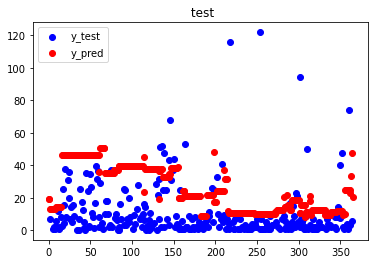

In [446]:
plotGraph(main_df['time_taken_final'], main_df['time_taken_mean'],' test')

{'whiskers': [<matplotlib.lines.Line2D at 0x11bd203cb00>,
 'caps': [<matplotlib.lines.Line2D at 0x11bd204c278>,
 'boxes': [<matplotlib.lines.Line2D at 0x11bd203c9b0>],
 'medians': [<matplotlib.lines.Line2D at 0x11bd204c978>],
 'fliers': [<matplotlib.lines.Line2D at 0x11bd204ccf8>],
 'means': []}

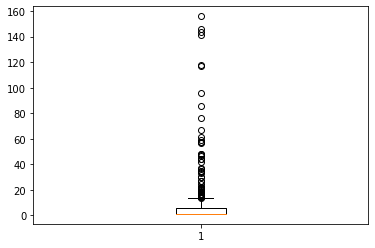

In [447]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [452]:
main_df = main_df[main_df['refactoring_perc_time_taken'] >= 2]
main_df = main_df[main_df['refactoring_perc_time_taken'] <= 40]

{'whiskers': [<matplotlib.lines.Line2D at 0x11bd217b358>,
 'caps': [<matplotlib.lines.Line2D at 0x11bd217ba90>,
 'boxes': [<matplotlib.lines.Line2D at 0x11bd217b208>],
 'medians': [<matplotlib.lines.Line2D at 0x11bd21c31d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x11bd21c3550>],
 'means': []}

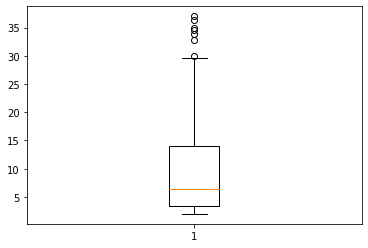

In [453]:
plt.boxplot(main_df['refactoring_perc_time_taken'])

In [454]:
main_df = main_df[main_df['time_taken_final'] <= 60]
main_df = main_df[main_df['time_taken_final'] > 2]

In [455]:
main_df['time_taken_final'].value_counts()

7.0     12
3.0      6
5.0      5
9.0      5
8.0      4
4.0      3
6.0      3
31.0     2
2.8      2
15.4     2
8.2      2
11.0     2
39.6     2
10.0     2
15.0     1
50.0     1
41.0     1
53.0     1
13.0     1
43.0     1
31.4     1
8.4      1
14.4     1
16.0     1
18.0     1
24.0     1
12.0     1
14.4     1
35.6     1
16.6     1
47.4     1
10.2     1
2.6      1
25.6     1
6.2      1
10.4     1
26.6     1
25.6     1
8.8      1
29.4     1
37.6     1
37.1     1
24.6     1
7.4      1
27.6     1
12.4     1
3.6      1
17.6     1
4.1      1
8.8      1
2.4      1
8.6      1
6.2      1
Name: time_taken_final, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x11bd2221048>,
 'caps': [<matplotlib.lines.Line2D at 0x11bd2221780>,
 'boxes': [<matplotlib.lines.Line2D at 0x11bd2210eb8>],
 'medians': [<matplotlib.lines.Line2D at 0x11bd2221e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x11bd222b240>],
 'means': []}

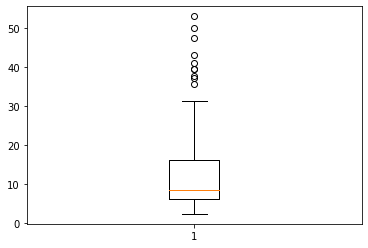

In [456]:
plt.boxplot(main_df['time_taken_final'])

In [457]:
main_df = main_df.fillna(0)

In [458]:
main_df

,kmean_label,time_taken_mean,time_taken_min,time_taken_max,time_taken_q10,time_taken_q20,time_taken_q25,time_taken_q30,time_taken_q40,time_taken_q50,...,num_line_affected_max,num_line_affected_std,actual_num_of_classes_touched_mean,actual_num_of_classes_touched_min,actual_num_of_classes_touched_max,actual_num_of_classes_touched_std,commit_line_changed,refactoring_perc,refactoring_perc_time_taken,time_taken_final
2,6,12.820546,1.0,166.0,1.0,1.0,2.0,2.0,3.0,5.0,...,61,0.000000,2.000000,2,2,0.000000,8,1.000000,15.000000,7.0
9,10,14.581832,1.0,152.0,1.0,1.2,2.0,2.0,4.0,6.0,...,764,0.000000,9.000000,9,9,0.000000,202,1.000000,10.000000,6.0
11,10,14.581832,1.0,152.0,1.0,1.2,2.0,2.0,4.0,6.0,...,115,0.000000,4.500000,3,6,2.121320,400,0.287500,9.487500,12.0
15,10,14.581832,1.0,152.0,1.0,1.2,2.0,2.0,4.0,6.0,...,47,0.000000,9.333333,1,14,7.234178,176,0.267045,5.340909,8.0
0,1,46.327198,1.0,167.0,2.0,6.6,11.0,16.0,22.2,28.0,...,175,78.488853,68.500000,59,78,13.435029,780,0.082051,2.051282,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,8,12.012698,1.0,167.0,1.0,1.0,2.0,2.0,3.0,4.0,...,60,0.000000,8.250000,1,12,4.621379,158,0.379747,16.708861,14.4
33,8,12.012698,1.0,167.0,1.0,1.0,2.0,2.0,3.0,4.0,...,763,0.000000,2.000000,2,2,0.000000,38,1.000000,37.000000,7.4
36,8,12.012698,1.0,167.0,1.0,1.0,2.0,2.0,3.0,4.0,...,411,0.000000,1.000000,1,1,0.000000,871,0.471871,36.334099,47.4
1,6,24.722772,1.0,148.0,2.0,3.0,4.0,6.0,10.4,14.0,...,907,362.783108,5.000000,2,8,2.581989,55,1.000000,13.000000,2.6


In [459]:
main_df.to_csv('test_effort_model.csv', index=False)

## EDA (Run only if absolutely necessary on minimum features)

In [460]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(main_df, title="Pandas Profiling Report",explorative=True)
#profile

In [461]:
for columns in main_df.columns:
    print(columns)

kmean_label
time_taken_mean
time_taken_min
time_taken_max
time_taken_q10
time_taken_q20
time_taken_q25
time_taken_q30
time_taken_q40
time_taken_q50
time_taken_q60
time_taken_q70
time_taken_q75
time_taken_q80
time_taken_q90
sha
name
email
date
login
message
parent_sha
parent_date
time_taken
contains_refactoring
project_name
commit_compared_with
cbo_mean
cbo_min
cbo_max
cbo_std
wmc_mean
wmc_min
wmc_max
wmc_std
dit_mean
dit_min
dit_max
dit_std
rfc_mean
rfc_min
rfc_max
rfc_std
lcom_mean
lcom_min
lcom_max
lcom_std
totalMethods_mean
totalMethods_min
totalMethods_max
totalMethods_std
staticMethods_mean
staticMethods_min
staticMethods_max
staticMethods_std
publicMethods_mean
publicMethods_min
publicMethods_max
publicMethods_std
privateMethods_mean
privateMethods_min
privateMethods_max
privateMethods_std
protectedMethods_mean
protectedMethods_min
protectedMethods_max
protectedMethods_std
defaultMethods_mean
defaultMethods_min
defaultMethods_max
defaultMethods_std
abstractMethods_mean
abstractMe

### Only taking mean for num_dependency and num_line_affected since there is only one

In [462]:
final_col = []
column_to_skip = ['sha',
'name','email','login',
'date','message',
'parent_sha','parent_date',
'time_taken','contains_refactoring',
'kmean_label','time_taken_mean',
'time_taken_min',
'time_taken_max',
'time_taken_q10',
'time_taken_q20',
'time_taken_q25',
'time_taken_q30',
'time_taken_q40',
'time_taken_q50',
'time_taken_q60',
'time_taken_q70',
'time_taken_q75',
'time_taken_q80',
'time_taken_q90',
'project_name','commit_compared_with',
'actual_num_of_classes_touched_mean',
 'actual_num_of_classes_touched_min',
 'actual_num_of_classes_touched_max',
 'actual_num_of_classes_touched_std',
'num_dependency_min',
'num_dependency_max',
'num_dependency_std',
'num_line_affected_min',
'num_line_affected_max',
'num_line_affected_std', 'time_taken_final',
'commit_line_changed',
'refactoring_perc'
 ]
for element in main_df.columns:
    #print("'" + element + "',")
    if element not in column_to_skip:
        final_col.append(element)

In [463]:
final_col

['cbo_mean',
 'cbo_min',
 'cbo_max',
 'cbo_std',
 'wmc_mean',
 'wmc_min',
 'wmc_max',
 'wmc_std',
 'dit_mean',
 'dit_min',
 'dit_max',
 'dit_std',
 'rfc_mean',
 'rfc_min',
 'rfc_max',
 'rfc_std',
 'lcom_mean',
 'lcom_min',
 'lcom_max',
 'lcom_std',
 'totalMethods_mean',
 'totalMethods_min',
 'totalMethods_max',
 'totalMethods_std',
 'staticMethods_mean',
 'staticMethods_min',
 'staticMethods_max',
 'staticMethods_std',
 'publicMethods_mean',
 'publicMethods_min',
 'publicMethods_max',
 'publicMethods_std',
 'privateMethods_mean',
 'privateMethods_min',
 'privateMethods_max',
 'privateMethods_std',
 'protectedMethods_mean',
 'protectedMethods_min',
 'protectedMethods_max',
 'protectedMethods_std',
 'defaultMethods_mean',
 'defaultMethods_min',
 'defaultMethods_max',
 'defaultMethods_std',
 'abstractMethods_mean',
 'abstractMethods_min',
 'abstractMethods_max',
 'abstractMethods_std',
 'finalMethods_mean',
 'finalMethods_min',
 'finalMethods_max',
 'finalMethods_std',
 'synchronizedMetho

In [464]:
X_col = final_col.copy()
X_col.remove('refactoring_perc_time_taken')
Y_col = ['refactoring_perc_time_taken']

X = main_df[X_col]
y = main_df[Y_col]
final_df = main_df[final_col]

In [465]:
X.head()

,cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,...,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean
2,11.0,11.0,11.0,0.00000,8.0,8.0,8.0,0.000000,2.0,2.0,...,58.0,58.0,58.0,0.00000,17.0,17.0,17.0,0.0,85.0,61.0
9,38.0,38.0,38.0,0.00000,57.0,57.0,57.0,0.000000,1.0,1.0,...,279.0,279.0,279.0,0.00000,17.0,17.0,17.0,0.0,322.0,764.0
11,4.0,4.0,4.0,0.00000,15.0,15.0,15.0,0.000000,1.0,1.0,...,108.0,108.0,108.0,0.00000,1.0,1.0,1.0,0.0,371.0,115.0
15,3.0,3.0,3.0,0.00000,5.0,5.0,5.0,0.000000,1.0,1.0,...,38.0,38.0,38.0,0.00000,16.0,16.0,16.0,0.0,23.0,47.0
0,21.5,20.0,23.0,2.12132,9.0,6.0,12.0,4.242641,3.0,3.0,...,68.0,54.0,82.0,19.79899,0.0,0.0,0.0,0.0,12.5,119.5


In [466]:
y.head()

,refactoring_perc_time_taken
2,15.000000
9,10.000000
11,9.487500
15,5.340909
0,2.051282


In [467]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=16)

In [468]:
h2o.init(nthreads=4)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 hours 27 mins
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,3 months and 15 days !!!
H2O_cluster_name:,H2O_from_python_tanji_eafnu9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.876 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [469]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_df)
train,test = full.split_frame(ratios=[.7])


x = train.columns
y = "refactoring_perc_time_taken"
x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%


In [470]:
train[x].types

{'cbo_mean': 'real',
 'cbo_min': 'int',
 'cbo_max': 'int',
 'cbo_std': 'real',
 'wmc_mean': 'real',
 'wmc_min': 'int',
 'wmc_max': 'int',
 'wmc_std': 'real',
 'dit_mean': 'real',
 'dit_min': 'int',
 'dit_max': 'int',
 'dit_std': 'real',
 'rfc_mean': 'real',
 'rfc_min': 'int',
 'rfc_max': 'int',
 'rfc_std': 'real',
 'lcom_mean': 'real',
 'lcom_min': 'int',
 'lcom_max': 'int',
 'lcom_std': 'real',
 'totalMethods_mean': 'real',
 'totalMethods_min': 'int',
 'totalMethods_max': 'int',
 'totalMethods_std': 'real',
 'staticMethods_mean': 'real',
 'staticMethods_min': 'int',
 'staticMethods_max': 'int',
 'staticMethods_std': 'real',
 'publicMethods_mean': 'real',
 'publicMethods_min': 'int',
 'publicMethods_max': 'int',
 'publicMethods_std': 'real',
 'privateMethods_mean': 'real',
 'privateMethods_min': 'int',
 'privateMethods_max': 'int',
 'privateMethods_std': 'real',
 'protectedMethods_mean': 'real',
 'protectedMethods_min': 'int',
 'protectedMethods_max': 'int',
 'protectedMethods_std': 'r

In [471]:
train[y].types

{'refactoring_perc_time_taken': 'real'}

In [472]:
aml = H2OAutoML(max_models=10, seed=16, exclude_algos=['XGBoost', 'GLM'], exploitation_ratio=0.1)
#aml = H2OAutoML(max_models=10, seed=1, include_algos=['GLM'])
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |███████
09:41:14.212: Skipping training of model GBM_5_AutoML_20211218_094109 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_5_AutoML_20211218_094109.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 65.0.


█████████████████████████████████████████████████| 100%


In [473]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_3_AutoML_20211218_094109,75.0922,8.66557,75.0922,7.14097,0.730541
XRT_1_AutoML_20211218_094109,75.4792,8.68788,75.4792,7.076,0.72166
GBM_grid__1_AutoML_20211218_094109_model_2,75.9605,8.71553,75.9605,7.0745,0.724309
StackedEnsemble_AllModels_AutoML_20211218_094109,77.3073,8.79246,77.3073,7.18857,0.738041
GBM_grid__1_AutoML_20211218_094109_model_1,77.3514,8.79496,77.3514,6.86085,0.72135
StackedEnsemble_BestOfFamily_AutoML_20211218_094109,77.3563,8.79524,77.3563,7.17915,0.73972
GBM_4_AutoML_20211218_094109,77.4958,8.80317,77.4958,7.39343,0.740607
GBM_2_AutoML_20211218_094109,78.9432,8.885,78.9432,7.30103,0.731559
GBM_1_AutoML_20211218_094109,79.2631,8.90298,79.2631,7.19651,0.723675
DRF_1_AutoML_20211218_094109,80.7739,8.98743,80.7739,7.2849,0.718162


In [474]:
model = h2o.get_model(lb[0,'model_id'])

In [475]:
model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_3_AutoML_20211218_094109


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,36.0,36.0,4019.0,2.0,4.0,3.027778,3.0,5.0,4.194445




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 20.44073808063904
RMSE: 4.521143448358948
MAE: 3.518501248726478
RMSLE: 0.41390318036615775
Mean Residual Deviance: 20.44073808063904

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 75.09216777664216
RMSE: 8.66557371306956
MAE: 7.140970269687863
RMSLE: 0.730541231308659
Mean Residual Deviance: 75.09216777664216

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,7.14097,1.6656622,7.780175,8.343046,4.708797,8.6922245,6.1806083
1,mean_residual_deviance,75.09217,25.949245,83.34791,101.02975,41.3515,95.04012,54.691563
2,mse,75.09217,25.949245,83.34791,101.02975,41.3515,95.04012,54.691563
3,r2,-0.11853469,0.37485796,-0.11501855,0.040612254,0.42042333,-0.4771549,-0.4615356
4,residual_deviance,75.09217,25.949245,83.34791,101.02975,41.3515,95.04012,54.691563
5,rmse,8.551121,1.5694363,9.129507,10.051355,6.4305134,9.748853,7.3953743
6,rmsle,0.7210391,0.13130632,0.8016694,0.77035034,0.4904536,0.8013468,0.74137545



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2021-12-18 09:41:12,0.321 sec,0.0,8.693611,7.001351,75.578879
1,,2021-12-18 09:41:12,0.334 sec,5.0,7.476047,6.019336,55.891284
2,,2021-12-18 09:41:12,0.348 sec,10.0,6.744302,5.494907,45.485609
3,,2021-12-18 09:41:12,0.360 sec,15.0,6.244915,5.007897,38.998969
4,,2021-12-18 09:41:12,0.373 sec,20.0,5.674870,4.534159,32.204147
5,,2021-12-18 09:41:12,0.386 sec,25.0,5.330535,4.225631,28.414602
6,,2021-12-18 09:41:12,0.398 sec,30.0,4.894254,3.816630,23.953720
7,,2021-12-18 09:41:12,0.410 sec,35.0,4.589062,3.549989,21.059494
8,,2021-12-18 09:41:12,0.413 sec,36.0,4.521143,3.518501,20.440738



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,variablesQty_min,2823.740234,1.000000,0.143644
1,assignmentsQty_min,2393.732910,0.847717,0.121769
2,mathOperationsQty_min,2081.889893,0.737281,0.105906
3,rfc_min,911.663330,0.322857,0.046376
4,uniqueWordsQty_min,847.684875,0.300199,0.043122
5,loc_min,836.725220,0.296318,0.042564
6,lcom_min,827.429138,0.293026,0.042091
7,protectedMethods_mean,720.066223,0.255004,0.036630
8,variablesQty_mean,656.785156,0.232594,0.033411
9,cbo_mean,606.902100,0.214928,0.030873



See the whole table with table.as_data_frame()


In [476]:
preds = model.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [477]:
preds

predict
14.2736
19.5498
14.4064
17.1741
6.88398
15.3523
9.10856
7.82638
7.57224
6.44186


In [478]:
pd_preds = preds.as_data_frame()
pd_preds['predict'].value_counts()

11.925131    1
13.790026    1
13.325738    1
4.924496     1
15.352283    1
5.825249     1
19.549781    1
9.347266     1
13.563403    1
7.826377     1
6.883982     1
17.174108    1
9.803586     1
14.406380    1
6.997427     1
9.108564     1
14.273643    1
8.032235     1
6.441863     1
9.342895     1
7.572241     1
6.783170     1
6.250938     1
18.502999    1
17.953179    1
8.802389     1
Name: predict, dtype: int64

In [479]:
train

cbo_mean,cbo_min,cbo_max,cbo_std,wmc_mean,wmc_min,wmc_max,wmc_std,dit_mean,dit_min,dit_max,dit_std,rfc_mean,rfc_min,rfc_max,rfc_std,lcom_mean,lcom_min,lcom_max,lcom_std,totalMethods_mean,totalMethods_min,totalMethods_max,totalMethods_std,staticMethods_mean,staticMethods_min,staticMethods_max,staticMethods_std,publicMethods_mean,publicMethods_min,publicMethods_max,publicMethods_std,privateMethods_mean,privateMethods_min,privateMethods_max,privateMethods_std,protectedMethods_mean,protectedMethods_min,protectedMethods_max,protectedMethods_std,defaultMethods_mean,defaultMethods_min,defaultMethods_max,defaultMethods_std,abstractMethods_mean,abstractMethods_min,abstractMethods_max,abstractMethods_std,finalMethods_mean,finalMethods_min,finalMethods_max,finalMethods_std,synchronizedMethods_mean,synchronizedMethods_min,synchronizedMethods_max,synchronizedMethods_std,totalFields_mean,totalFields_min,totalFields_max,totalFields_std,staticFields_mean,staticFields_min,staticFields_max,staticFields_std,publicFields_mean,publicFields_min,publicFields_max,publicFields_std,privateFields_mean,privateFields_min,privateFields_max,privateFields_std,protectedFields_mean,protectedFields_min,protectedFields_max,protectedFields_std,defaultFields_mean,defaultFields_min,defaultFields_max,defaultFields_std,finalFields_mean,finalFields_min,finalFields_max,finalFields_std,synchronizedFields_mean,synchronizedFields_min,synchronizedFields_max,synchronizedFields_std,nosi_mean,nosi_min,nosi_max,nosi_std,loc_mean,loc_min,loc_max,loc_std,returnQty_mean,returnQty_min,returnQty_max,returnQty_std,loopQty_mean,loopQty_min,loopQty_max,loopQty_std,comparisonsQty_mean,comparisonsQty_min,comparisonsQty_max,comparisonsQty_std,tryCatchQty_mean,tryCatchQty_min,tryCatchQty_max,tryCatchQty_std,parenthesizedExpsQty_mean,parenthesizedExpsQty_min,parenthesizedExpsQty_max,parenthesizedExpsQty_std,stringLiteralsQty_mean,stringLiteralsQty_min,stringLiteralsQty_max,stringLiteralsQty_std,numbersQty_mean,numbersQty_min,numbersQty_max,numbersQty_std,assignmentsQty_mean,assignmentsQty_min,assignmentsQty_max,assignmentsQty_std,mathOperationsQty_mean,mathOperationsQty_min,mathOperationsQty_max,mathOperationsQty_std,variablesQty_mean,variablesQty_min,variablesQty_max,variablesQty_std,maxNestedBlocks_mean,maxNestedBlocks_min,maxNestedBlocks_max,maxNestedBlocks_std,anonymousClassesQty_mean,anonymousClassesQty_min,anonymousClassesQty_max,anonymousClassesQty_std,subClassesQty_mean,subClassesQty_min,subClassesQty_max,subClassesQty_std,lambdasQty_mean,lambdasQty_min,lambdasQty_max,lambdasQty_std,uniqueWordsQty_mean,uniqueWordsQty_min,uniqueWordsQty_max,uniqueWordsQty_std,modifiers_mean,modifiers_min,modifiers_max,modifiers_std,num_dependency_mean,num_line_affected_mean,refactoring_perc_time_taken
3,3,3,0,5,5,5,0,1,1,1,0,5,5,5,0,2,2,2,0,5,5,5,0,0,0,0,0,5,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,5,5,5,0,33,33,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,38,38,38,0,16,16,16,0,23,47,5.34091
21.5,20,23,2.12132,9,6,12,4.24264,3,3,3,0,25,15,35,14.1421,37.5,15,60,31.8198,9,6,12,4.24264,3.5,0,7,4.94975,0,0,0,0,3.5,0,7,4.94975,0.5,0,1,0.707107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.5,1,4,2.12132,2.5,1,4,2.12132,0,0,0,0,2.5,1,4,2.12132,0,0,0,0,0,0,0,0,2.5,1,4,2.12132,0,0,0,0,43.5,16,71,38.8909,121,60,182,86.267,3.5,0,7,4.94975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,10,86,53.7401,0,0,0,0,10,9,11,1.41421,0,0,0,0,10,9,11,1.41421,0,0,0,0,0,0,0,0,0,0,0,0,7,4,10,4.24264,68,54,82,19.799,0,0,0,0,12.5,119.5,2.05128
11,11,11,0,6,6,6,0,3,3,3,0,15,15,15,0,15,15,15,0,6,6,6,0,2,2,2,0,4,4,4,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,24,24,0,111,111,111,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,34,34,0,30,30,30,0,8,8,8,0,0,0,0,0,8,8,8,0,0,0,0,0,0,0,0,0,2,2,2,0,0,0,0,0,75,75,75,0,1,1,1,0,20,96,7.12166
5,5,5,0

{'whiskers': [<matplotlib.lines.Line2D at 0x11bd25c6e80>,
 'caps': [<matplotlib.lines.Line2D at 0x11bd25d15f8>,
 'boxes': [<matplotlib.lines.Line2D at 0x11bd25c6d30>],
 'medians': [<matplotlib.lines.Line2D at 0x11bd25d1cf8>],
 'fliers': [<matplotlib.lines.Line2D at 0x11bd25c66a0>],
 'means': []}

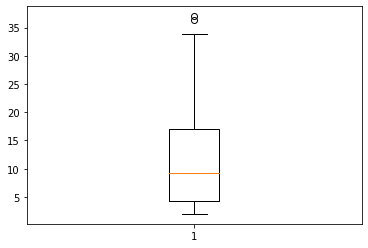

In [480]:
pd_train = train.as_data_frame()
plt.boxplot(pd_train['refactoring_perc_time_taken'])

In [498]:
main_df['actual_num_of_classes_touched_max'].mean()

11.956043956043956

In [481]:
len(main_df['actual_num_of_classes_touched_max'])

91

In [482]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 1000])

91

In [483]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 100])

91

In [484]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 50])

87

In [485]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 20])

75

In [486]:
len(main_df[main_df['actual_num_of_classes_touched_max'] < 10])

56

{'whiskers': [<matplotlib.lines.Line2D at 0x11bd2661ba8>,
 'caps': [<matplotlib.lines.Line2D at 0x11bd2672320>,
 'boxes': [<matplotlib.lines.Line2D at 0x11bd2661a58>],
 'medians': [<matplotlib.lines.Line2D at 0x11bd26729e8>],
 'fliers': [<matplotlib.lines.Line2D at 0x11bd2672d30>],
 'means': []}

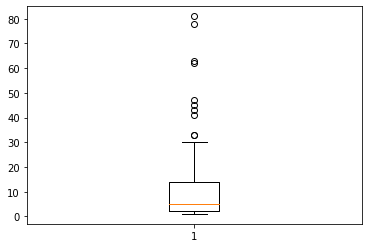

In [487]:
plt.boxplot(main_df['actual_num_of_classes_touched_max'])

In [488]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 1000]

{'whiskers': [<matplotlib.lines.Line2D at 0x11bd26cf588>,
 'caps': [<matplotlib.lines.Line2D at 0x11bd26cfcc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x11bd26cf438>],
 'medians': [<matplotlib.lines.Line2D at 0x11bd26dd400>],
 'fliers': [<matplotlib.lines.Line2D at 0x11bd26dd780>],
 'means': []}

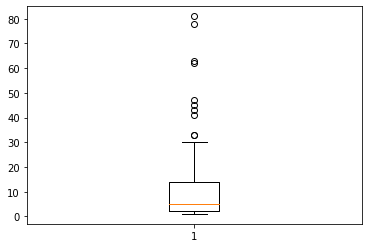

In [489]:
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

{'whiskers': [<matplotlib.lines.Line2D at 0x11bd2739048>,
 'caps': [<matplotlib.lines.Line2D at 0x11bd2739780>,
 'boxes': [<matplotlib.lines.Line2D at 0x11bd2728eb8>],
 'medians': [<matplotlib.lines.Line2D at 0x11bd2739e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x11bd2743240>],
 'means': []}

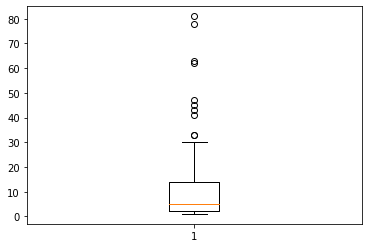

In [490]:
main_df_num_of_classes_without_outliers = main_df[main_df['actual_num_of_classes_touched_max'] < 100]
plt.boxplot(main_df_num_of_classes_without_outliers['actual_num_of_classes_touched_max'])

In [491]:
pd_test = test.as_data_frame()
pd_preds['actual_time_taken'] = pd_test['refactoring_perc_time_taken']

In [492]:
pd_preds

,predict,actual_time_taken
0,14.273643,15.000000
1,19.549781,10.000000
2,14.406380,9.487500
3,17.174108,27.153976
4,6.883982,2.547895
5,15.352283,12.574074
6,9.108564,5.606557
7,7.826377,4.462687
8,7.572241,12.254902
9,6.441863,5.151862


{'whiskers': [<matplotlib.lines.Line2D at 0x11bd2792eb8>,
 'caps': [<matplotlib.lines.Line2D at 0x11bd279f630>,
 'boxes': [<matplotlib.lines.Line2D at 0x11bd2792d68>],
 'medians': [<matplotlib.lines.Line2D at 0x11bd279fd30>],
 'fliers': [<matplotlib.lines.Line2D at 0x11bd27a70f0>],
 'means': []}

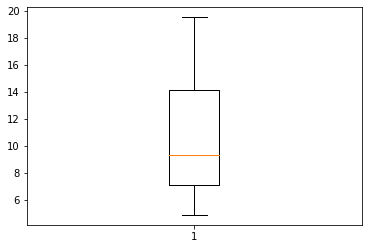

In [493]:
plt.boxplot(pd_preds['predict'])

{'whiskers': [<matplotlib.lines.Line2D at 0x11bd2802208>,
 'caps': [<matplotlib.lines.Line2D at 0x11bd2802940>,
 'boxes': [<matplotlib.lines.Line2D at 0x11bd28020b8>],
 'medians': [<matplotlib.lines.Line2D at 0x11bd280d080>],
 'fliers': [<matplotlib.lines.Line2D at 0x11bd280d400>],
 'means': []}

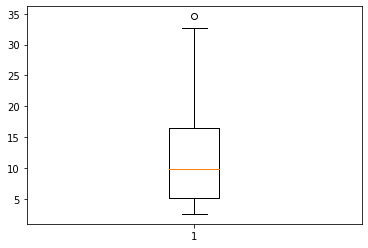

In [494]:
plt.boxplot(pd_preds['actual_time_taken'])

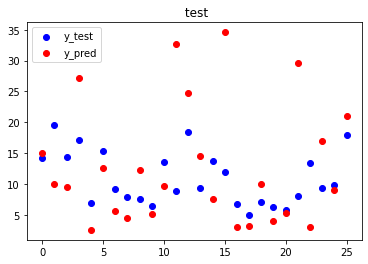

In [495]:
plotGraph(pd_preds['predict'], pd_preds['actual_time_taken'],' test')

In [497]:
# save the model
model_path = h2o.save_model(model=model, path="models/EffortEstimationModelv2", force=True)

Documentation at the following

https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/h2o/explanation/_explain.html

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

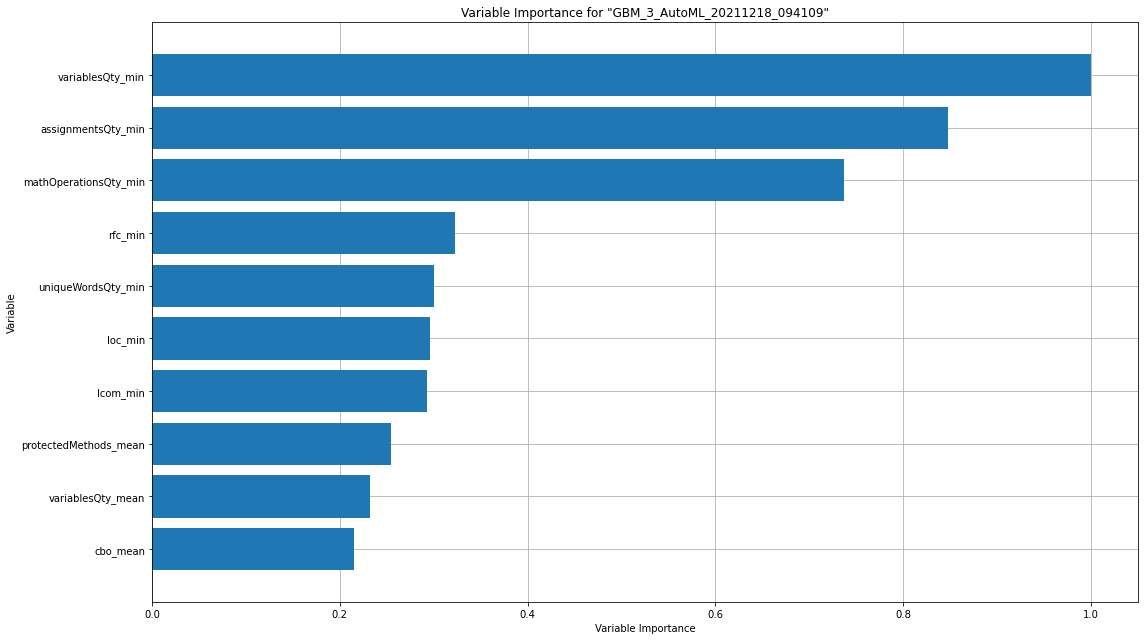

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

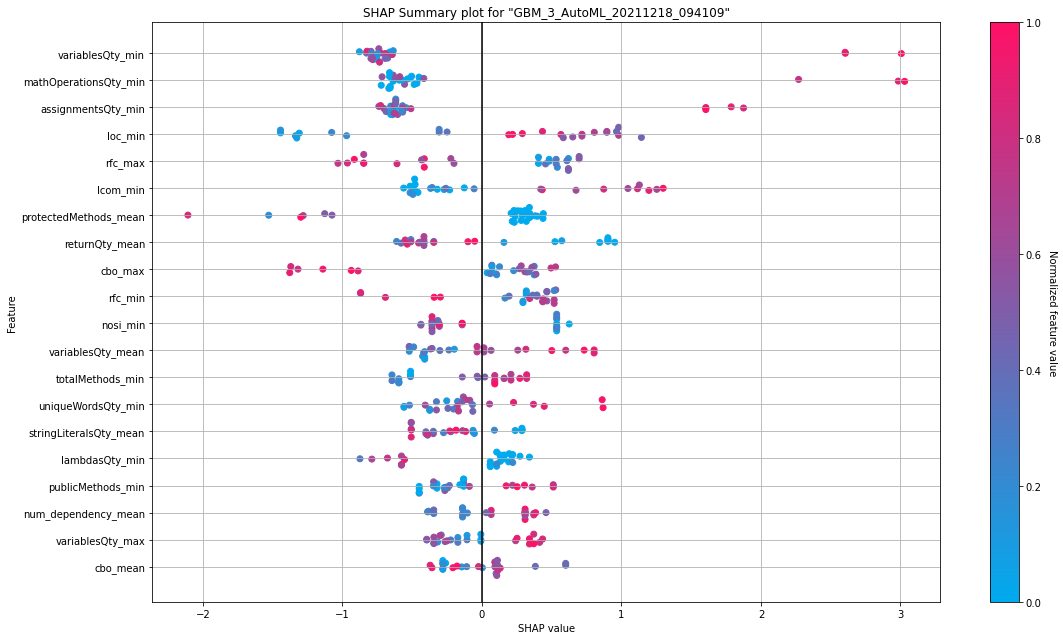

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

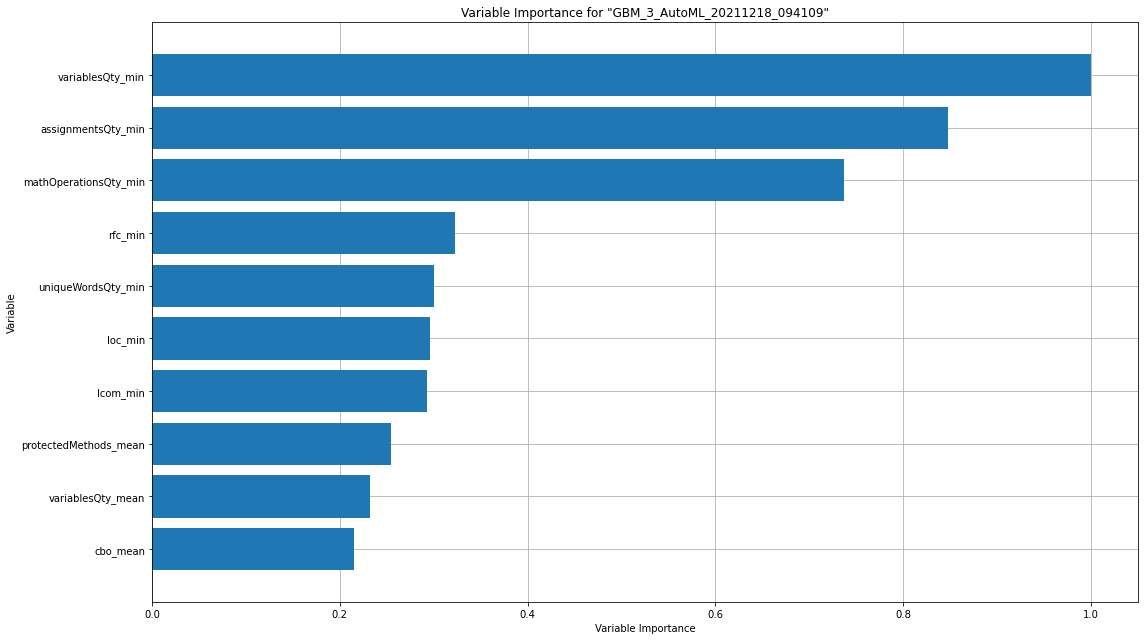

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

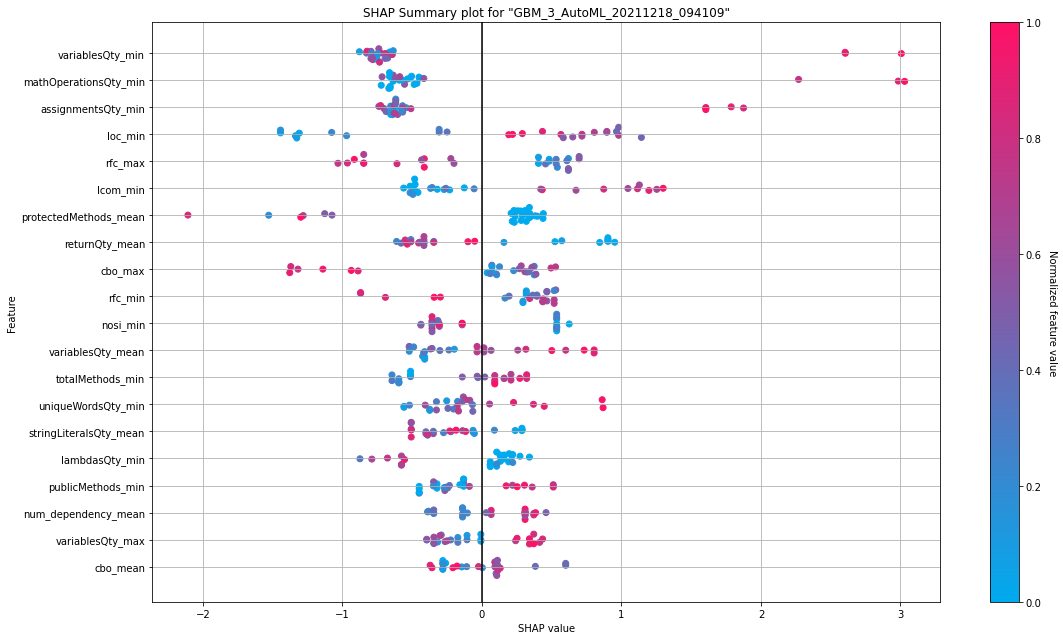

In [496]:
aml.explain(test, include_explanations=["varimp",'shap_summary'])

In [65]:
#aml.explain_row(test, row_index=0)

In [66]:
#h2o.shutdown()